# Workbook 03- Regression

by [Dr. David Elliott](https://eldave93.netlify.app/) and [Dr. Harry Gulliver](https://uk.linkedin.com/in/harry-gulliver-18a5a2188)

1. [Workspace Setup](#setup)

2. [Problem Understanding](#problem)

3. [Data Preparation](#prep)

4. [Exploratory Data Analysis](#eda)

5. [Data Pre-Processing](#pre)

6. [Model Exploration/Refinement](#explore)

7. [Summary](#sum)

8. [Extra](#extra)

Lets start to focus on understanding some regression models. Regression models are used to predict _continuous_ output variables but are generally very flexible (which is why they are so common).

To engage with the workshop material, it is assumed that you have some knowledge of data manipulation and visualisation in Python from previous experience and courses, and worked through workbook 01.

# 1. Workspace Setup
Before downloading any data we should think about our workspace. It is assumed if you have made it this far you have already got your workspace setup. There are two ways of using these notebooks. The first is to use Google Colab, which is a website that allows you to write and execute python code through the browser. The second is a local workspace (e.g. Anaconda).

## 1.A. Google Colab
If you are not using google colab then you can skip this section. 

If you are using colab we will first need to have the libaries for the runtime and files associated with this workbook uploaded to the temporary file store. You also need to set the working directory to be a local version of the workshop repository. This is so all the data, images, and scripts for displaying the solutions works. This is located on the temporary file store associated with this colabs runtime. The below code will do all this for you.

__Required:__ After running this code make sure to restart the runtime to ensure everything works correctly (Runtime > Restart runtime).

In [1]:
import sys
import os

try:
    import google.colab
    COLAB=True
    
    # set the workbook code
    WORKSHOP_NAME = "03-regression"
    # set the folder name
    FOLDER_NAME = "machine-learning-workbooks-main"

    # check if the environment is already setup to avoid repeating this after 
    # restarting the runtime
    if not os.path.exists(FOLDER_NAME):
        # get the zip of the workbooks
        !wget https://github.com/Eldave93/machine-learning-workbooks/archive/refs/heads/main.zip
        # unzip the file
        !unzip main.zip
        # install the libaries
        !{sys.executable} -m pip install -r ./{FOLDER_NAME}/scripts/requirements.txt
          
    print("Setting working directory to:")
    %cd ./{FOLDER_NAME}/{WORKSHOP_NAME}
    
except:
    COLAB=False
    print("Colab is not being used")

Colab is not being used


## 1.1. Packages

If your using a local workspace you will need all the following packages to run this notebook. If you do not already have them, or you want to ensure you are using the same versions as used when created, you could run `!{sys.executable} -m pip install -r ../scripts/requirements.txt` to install them for you.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import sys

sys.path.append('../scripts') # add scripts to the path for use later
sns.set(rc={'figure.figsize': (14, 8)}) # For plot sizes
np.random.seed(42)  # to make this notebook's output identical at every run

# colours for print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## 1.2. Displaying solutions

The solutions are activated using a new .txt file which can be put in the workbook folder (e.g. `05-regression`). Please put in a request for access.

If you have access to the solutions, the following cell will create clickable buttons under each exercise, which will allow you to reveal the solutions.

__Notes__

- This method was created by [Charlotte Desvages](https://charlottedesvages.com/).
- This may not work if you don't have the same version of `IPython.display` as the machine that created them:
    ```
    ImportError: cannot import name 'Code' from 'IPython.display' (/usr/local/lib/python3.7/dist-packages/IPython/display.py)
    ```
    If so run the auto-install above or manually run `!pip install ipython==7.20`.

In [4]:
%run ../scripts/create_widgets.py 03

Solutions .txt file not found!


---

# 2. Problem Understanding <a id='problem'></a>

We'll be working with a dataset from Capital Bikeshare that was used in a [Kaggle competition](https://www.kaggle.com/c/bike-sharing-demand/). The objective of the competition was to predict total ridership of Capital Bikeshare in any given hour.

Demand forecasting is a common data science application. If we can predict the quantity of demand, total ridership in a given hour, we can create analytical tools to improve the bikeshare system. Some applications would be:
* Find where to site new bikeshare stations and know how large of a station to build.
* Calculate the expected wear and tear on bikes and what the replacement costs will be.
* Use a slightly different research design to forecast full and empty stations and send a service vehicle to "rebalance" the bikes from one station to another, as sometimes bikeshare stations have no bikes or are completely full and prevent use of the station.

Businesses aren't new to demand forecasting, but older methods suffered from poor predictions at atypical small locations. Modern approaches incorporate clusters and online data from Twitter and Google Trends to improve prediction in these small locations.

## 2.1. Data Download

We could read the data in from Kaggle (see notebook 2 for an example), but for now lets just read it in using the data stored in the "Data" folder.

In [5]:
bikes = pd.read_csv('./Data/bikeshare.csv')

bikes.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Lets have a look at what variables we have in our data to work with.

In [6]:
bikes.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

Below is a [__Data Dictionary__](https://www.kaggle.com/c/bike-sharing-demand/data) which describes what each feature represents.

- `datetime` - hourly date + timestamp  
- `season` -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- `holiday` - whether the day is considered a holiday
- `workingday` - whether the day is neither a weekend nor holiday
- `weather` 
            1: Clear, Few clouds, Partly cloudy, Partly cloudy
            2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- `temp` - temperature in Celsius
- `atemp` - "feels like" temperature in Celsius
- `humidity` - relative humidity
- `windspeed` - wind speed
- `casual` - number of non-registered user rentals initiated
- `registered` - number of registered user rentals initiated
- `count` - number of total rentals

---

### 🚩 Exercise 1

Based on the problem outline, what attribute of this data would you assign to be the `output` variable for the model (the thing we are trying to predict)?

- Write it below as a string.

In [7]:
output = ""

In [8]:
%run ../scripts/show_solutions.py 03_ex1

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 2

How many features are there?

In [9]:
%run ../scripts/show_solutions.py 03_ex2

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 3

Based on the data dictionary descriptions, can you identify any potential problematic features if used to predict our output variable? 

- If so remove them from the data.

In [10]:
%run ../scripts/show_solutions.py 03_ex3

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

To recap (_spoilers for the answers above_), from the data we have, our aim is to create something that can take the attributes (`datetime`...`registered`) and give us a prediction of the number of riders (`count`). To do this we need to learn from the data we have available (already with the number of riders on each day) so in the future we can collect information such as the temperature to help us predict how many riders there may be. So for example, say we have measured the following attributes from an area:

In [11]:
output = "count"

# set the random seed so the same example is selected each time
np.random.seed(45)

# select a random wine example
example = bikes.sample()

# remove our `quality` attribute
X_example = example.drop(output, axis=1)

X_example

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered
7975,2012-06-12 16:00:00,2,0,1,2,27.06,29.545,89,19.0012,30,209


The aim for this workshop is to create a model (e.g. `example_lin_pipe`) that we can input the above information in and make a prediction...

In [12]:
# this is just a bit of code I wrote to create a trained model
from helper_functions import create_example_bike_model, bike_data_prep

# Don't worry about understanding this line of code - you will learn how to create your
# own `lin_pipe` without using `create_example_model` as this is just an example so you
# don't need to see the code that went into making this model yet.
example_lin_pipe = create_example_bike_model(bikes.drop(example.index[0]), output)

# make a prediction with our model (rounded)
example_lin_pipe.predict(bike_data_prep(X_example)).round()

array([267.])

So the model above has made a prediction that an area with those attributes would be predicted to have 267 riders at that time ("2012-06-12 16:00:00"). Now because in this case that place was already measured lets see how well our model did to predict the number of riders...

In [13]:
example.loc[:,output]

7975    239
Name: count, dtype: int64

So it predicted 239 riders. Being 28 riders off is not bad (or maybe it is... depends on how accurate the buisness needs it to be...). However as we'll see later this model can be off by a lot more than that (this is a hard problem!). 

Right now lets have a look at how we can make our own model to do this (essentially what I did inside the function `create_example_bike_model`)!

---

# 3. Data Preparation  <a id='prep'></a>

This data could do with a little cleaning up before we start to explore it. For example, `count` is not a good name for an attribute of the data as this is a command in Pandas and could be confusing.

---

### 🚩 Exercise 4

- Rename the `count` column to `riders`.
- Rename `atemp` to `realfeel` so its a bit clearer.

<br>
<details><summary><b><u>Hint</b></u></summary>
    
You can use the `.rename()` pandas method
    
</details>

In [14]:
# rename the output to riders
output = "riders"


In [15]:
%run ../scripts/show_solutions.py 03_ex4

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
If we look at the datatypes of the variables, we notice most are in their correct format, however our `datetime` variable is an `object` (so string, essentially).

In [16]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


 We should convert it to a `datetime` object so it is correctly treated as a date and time (useful for plots!)

In [17]:
bikes['datetime'] = pd.to_datetime(bikes['datetime'], format='%Y-%m-%d %H:%M:%S')

bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


It also makes sense to set it as the index, since each record is at a single time.

In [18]:
bikes.set_index('datetime', inplace=True)

bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


---

### 🚩Exercise 5a (Extra)

We could turn all these preparation steps above into a function. 
- Why might this be useful?

In [19]:
%run ../scripts/show_solutions.py 03_ex5a

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 5b (Extra)

Turn these preparation steps into a function.

__Note__
- You can use a `FunctionTransformer` to make it compatible with a scikit-learn pipeline. Its not a _"sampler"_ as we are not removing _observations_, just changing features (see workbook 1 for more information)!

In [20]:
%run ../scripts/show_solutions.py 03_ex5b

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
I made a helper function to do this cleaning above so I'll run the data through this just in case you struggled.

In [21]:
bikes = bike_data_prep(pd.read_csv('./Data/bikeshare.csv'))
bikes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   realfeel    10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   riders      10886 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 850.5 KB


---
We have another important preparation step to do, split our data into training and test sets! As our data is a time series, it does make sense to try account for this order in how we split up our data.

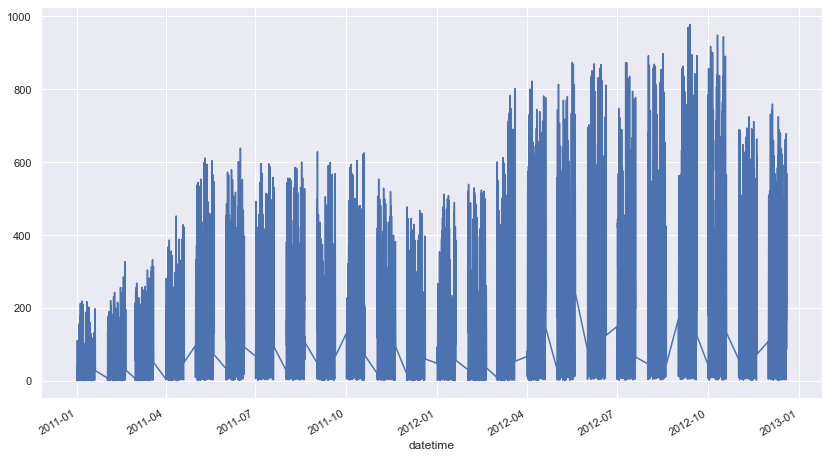

In [22]:
bikes.riders.plot();

---

Notice the missing data towards the end of each month as indicated by the gaps with a straight line between them. This is because in the competition originally the end of each month (from the 20th) was used as the test set. You could load in the test set from the competition and append it to our data, but it would still be missing the riders information as shown below.

__Note__
- The line where there are missing values have been added when plotting by matplotlib, they don't exist in our data.
- In Kaggle competitions the organiser will keep the output variable in the test set hidden to evaluate model performance independently to prevent cheating.
- This demonstrates why making functions is a good idea, as I can easily apply the same preparation steps to this new data.

In [23]:
orig_test = bike_data_prep(pd.read_csv('./Data/test.csv'))

orig_test.head()

,season,holiday,workingday,weather,temp,realfeel,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


---

For our test set in this workbook, we could split the data at some point and use the first chunk for training and second for testing.

We'll make our test set roughly the last business quarter (Q4 2013).

In [24]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(bikes,            # data to split
                                     test_size=0.125,  # we will leave 12.5% to test our models on later
                                     random_state=42,  # make our work reproducable 
                                     shuffle=False)    # keep data ordering!

train_df.tail()

,season,holiday,workingday,weather,temp,realfeel,humidity,windspeed,riders
datetime,,,,,,,,,
2012-10-01 01:00:00,4,0,1,1,18.04,21.970,77,6.0032,18
2012-10-01 02:00:00,4,0,1,1,18.86,22.725,72,0.0000,12
2012-10-01 03:00:00,4,0,1,1,18.04,21.970,77,0.0000,7
2012-10-01 04:00:00,4,0,1,1,17.22,21.210,82,7.0015,10
2012-10-01 05:00:00,4,0,1,1,18.04,21.970,77,0.0000,36


In [25]:
test_df.head()

,season,holiday,workingday,weather,temp,realfeel,humidity,windspeed,riders
datetime,,,,,,,,,
2012-10-01 06:00:00,4,0,1,1,18.04,21.970,77,7.0015,155
2012-10-01 07:00:00,4,0,1,1,18.04,21.970,77,11.0014,483
2012-10-01 08:00:00,4,0,1,2,18.86,22.725,77,7.0015,784
2012-10-01 09:00:00,4,0,1,2,21.32,25.000,63,0.0000,340
2012-10-01 10:00:00,4,0,1,1,22.14,25.760,56,0.0000,179


There is an upward trend (more riders over time) which will likely not be captured if we trained on earlier data to predict later data. However if we did randomly shuffle our data it will inflate performance metrics since they allow the training model to cheat because observations "from the future" (posterior samples) leak into the training that the model would not have access to when used in practice in the future. So lets stick with what we have done while keeping this limitation in back of our minds!

---

### 🚩 Exercise 6 (Extra)

Try split the data so we test our model exactly starting with October 1 2012's data.

<br>
<details><summary><b><u>Hint</b></u></summary>
    
- Using Pandas `.loc` will probably be easiest here.
- To work with datetime objects it helps to use the `datetime` library.
    
</details>

In [26]:
%run ../scripts/show_solutions.py 03_ex6

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

# 4. Exploratory Data Analysis <a id='eda'></a>

It is important to have a general feeling for what the data looks like before building a model. Ideally, before creating the model you would have some sense of which variables might matter most to predict the response. This dataset is fairly intuitive (and the purpose of this lesson is not visualization), so we will keep the visualization short.

Lets first create a copy of our training set so anything we do doesn't accidently alter it.

In [27]:
explore_set = train_df.copy()

---

### 🚩 Exercise 7

Using our `explore_set`, produce a scattergraph of temperature vs the number of riders. 

- How strong a predictor do you think temperature is of the number of riders? 
- Can you think of any reasons why this may be?

In [28]:
%run ../scripts/show_solutions.py 03_ex7

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
### 🚩 Exercise 8 

Using scattergraph's explore how other features relate to the number of riders.

In [29]:
%run ../scripts/show_solutions.py 03_ex8

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 9

Examine if/which of the features are correlated to each other.

- Can you think of any reason why certain features may be correlated?

<br>
<details><summary><b><u>Hint</b></u></summary>
    
- You can combine `sns.heatmap` with the pandas function `.corr()`
    
</details>

In [30]:
%run ../scripts/show_solutions.py 03_ex9

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

If two features are highly correlated the model gets very little new information from the second feature (_multicollinearity_). It can accurately determine the combined effect of the two features, but can't determine how to divide that effect between the bit coming from one feature and the bit coming from the other. E.g., if an increase of both `temp` and `realfeel` by 1 degree each causes 10 extra riders (on average), how many extra riders do you get from a 1 degree increase in `temp` alone? Is it 5 (with the other 5 coming from the 1 degree increase in `realfeel`)? Is it 9 (and 1 from `realfeel`)? 15 and -5? Etc.

So highly correlated features cause very unstable estimates of the _"coefficients"_ (more on this later) when fitting the model and make the model unreliable.

So when selecting features for a linear model, we generally want ones that correlate strongly with the target (positively or negatively) but weakly with each other.

---

### 🚩 Exercise 10
Are any of the features correlated with our output variable?

- If you had to use this to pick two features to use to predict the output, which would you pick?

__Note__
- Correlations only indicate __linear__ relationships with the output variable. This means that if the relationship is non-linear or useful when combined with other features, correlation alone will __not__ be able to pick this up! In otherwords, its useful to look at, but don't base your decision to keep/remove features solely using this!

In [31]:
%run ../scripts/show_solutions.py 03_ex10

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

# 5. Data Pre-Processing <a id='pre'></a>

Now we have some familiarity with the data though our data exploration, lets start preparing our data to be modelled. 

Lets start by removing `temp` from our training data as we don't need both `temp` and `realfeel`.

In [32]:
train_df.drop("temp", axis=1, inplace=True)

As we have prepared our data previously the data is quite clean already. The following exercises are extra in this case as (__spoiler alert__) the data is already in pretty good shape to be modelled. But feel free to do the steps below to double check this!

--- 
### 🚩 Exercise 11 (Extra)

How many duplicated observations are present in the features?

- How do you think these duplications ended up in the data?

<br>
<details><summary><b><u>Hint</b></u></summary>

With Pandas dataframes you can use `.duplicated()` to get a boolean of whether something is a duplicate and then use `.sum()` to count how many there are.
</details>

In [33]:
%run ../scripts/show_solutions.py 03_ex11

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

### 🚩 Exercise 12 (Extra)

Are there any missing values in the training data?

In [34]:
%run ../scripts/show_solutions.py 03_ex12

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 13 (Extra)

Can you identify any potential outliers using boxplots?

- Would you recommend to remove them?

In [35]:
%run ../scripts/show_solutions.py 03_ex13

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

# 6. Model Exploration/Refinement <a id='explore'></a>

As we saw in workbook 01, you would normally explore a series of models from different machine learning categories at this stage (e.g. linear, non-linear, forests, neural networks). We would normally do a first pass quickly looking at how different model types do before digging further into them (refinement) - but in this case as we are learning about a particular model in this workbook, it makes sense to blur the line between exploration and refinement here.

Before moving on we are going to split our data again into a training and validation set to ensure we don't keep checking our model performance on the test set. If we keep improving our model based on test set performance this set stops being useful as a truely independent measure of future generalisation performance!

In [36]:
y_train = train_df.loc[:,output]
X_train = train_df.drop(output, axis=1)
feature_names = list(X_train.columns)

print(X_train.shape)
print(y_train.shape)

(9525, 7)
(9525,)


In [37]:
# Lets keep a copy for when we want them later
X_train_full, y_train_full = X_train.copy(), y_train.copy()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, # data to split
                                                  test_size=0.15,    # we will leave 15% to test our models on later (roughly the last quater)
                                                  random_state=42,   # make our work reproducable 
                                                  shuffle=False)     # prevent data ordering affecting our model

## 6.1. Linear Regression

For our first model, we are going to try use `realfeel` to predict the number of `riders`. Lets remind ourselves of the data below:

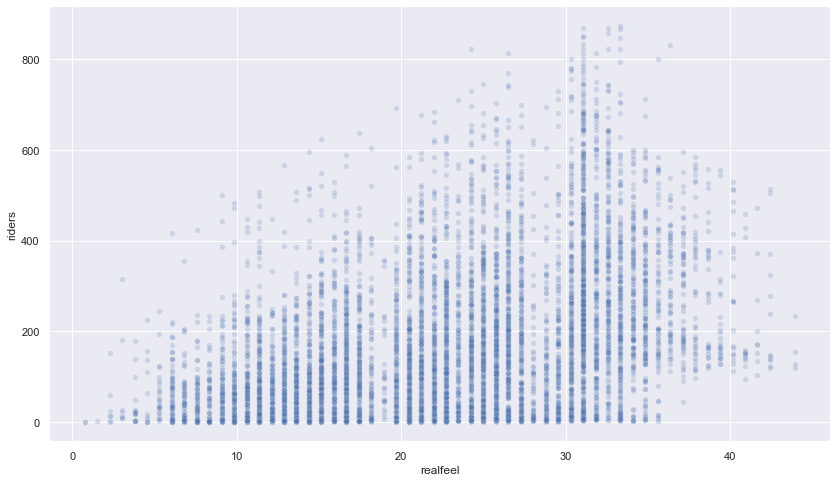

In [38]:
sns.scatterplot(x=X_train['realfeel'], y=y_train, alpha=0.2, s=30);

Essentially what we may want to do is to draw a straight line through this data to find the pattern that best fits the data. Using this line you can then make future predictions.

__Note__
- In the figure below, see the faint area around the line? This is the _"confidence interval"_. Without worrying about the details here, its just worth noting for now that indicates how certain we our of where the _"real"_ regression line may be based on this sample of data.

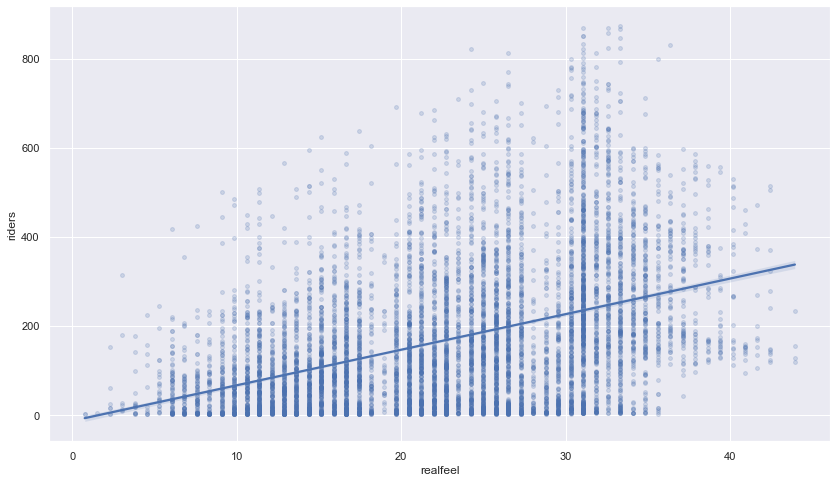

In [39]:
sns.regplot(x=X_train['realfeel'], y=y_train, scatter_kws={"alpha":0.2, "s":15});

The equation of a straight line is $$y=mx+c,$$ where $x$ is your independent variable (predictor), $y$ is the dependent variable (target), $m$ is the gradient (coefficient/effect size) and $c$ is the intercept (where line crosses y-axis).

Therefore to predict the target variable, you would read it as 

$$\text{prediction = effect size * x value + intercept}$$

The formula for linear regression is similar,

$$y = \beta_0 + \beta_1x.$$

We use beta to represent the model coefficients, which are the values the model learns (estimates) when finding the pattern which best fits the data. Beta0 ($\beta_0$) is the intercept, and beta1 ($\beta_1$) is the gradient. In linear regression we can read $\beta_1$ as the effect the predictor has on the target variable (for every 1 increase in $x$, how much will $y$ increase?). In other words, for every one increase in the predictor, how much will the target increase?

If you want to use the model for prediction, we have to edit the formula slightly and add an epsilon ($\epsilon$).This represents the fact that our model will have some random error built in that we cannot avoid (real data isn’t perfect, and so neither will our models!),

$$\hat y = \beta_0 + \beta_1x + \epsilon.$$

What makes this linear is that the $x$ terms are linear (i.e. not squared, cubed, etc). 

You don’t really have to worry about all this above too much, as we will see Python will calculate all this for us. This is so you are aware of the notation in case you see it elsewhere so you know what is going on.

Now lets look back at our example, how do we (and linear regression) know which is the best model (line) from all the possible options?

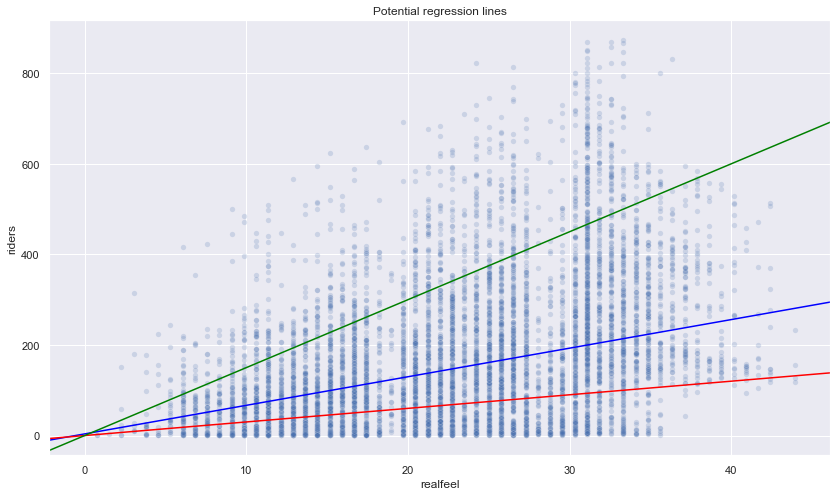

In [40]:
sns.scatterplot(x=X_train['realfeel'], y=y_train, alpha=0.2, s=30);
plt.axline((0, 3.63), slope=6.31, c="blue");
plt.axline((0, 0), slope=3, c="red");
plt.axline((0, 0), slope=15, c="green");

plt.title("Potential regression lines");

A linear regression model is going to find the line that best fits the data by finding the model that has the smallest difference between the regression line and the data. It’s incredibly rare that a set of data will form a perfect straight line, so we’d expect there to be some difference between the actual points and the line of best fit. These differences are called _residuals_ and are useful in evaluating how good our model is.

Lets have a look at an example sample of our data to see what I mean.

eval_env: 1


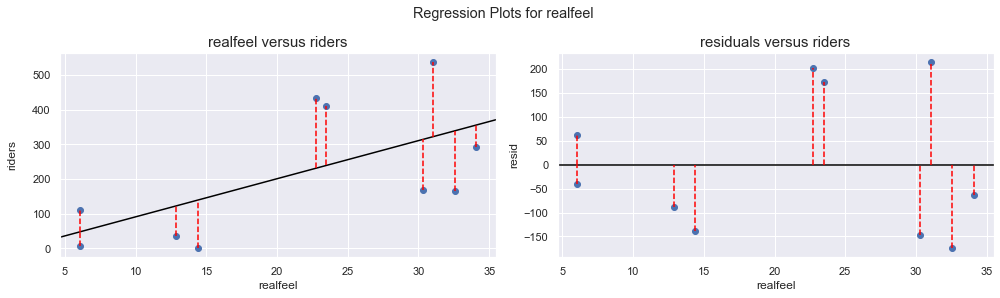

In [41]:
from helper_functions import example_residual_plot

np.random.seed(18)
example = train_df.sample(10)
    
example_residual_plot(example, 'realfeel', 'riders')

Basically, the smaller the residuals are, the better the model. For the sake of this workbook we are not going to worry too much how the computer finds the model with the smallest residuals, its just worth noting thats what it is doing.

Now lets get onto building our regression model. If you remember back to workbook 01, models in scikit-learn have a `.fit` function to learn from the training data. Lets start by using the feature `realfeel`.

In [42]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train[["realfeel"]], y_train)

LinearRegression()

Lets check the models coefficient and intercept.

In [43]:
print(lr.coef_.round(2))
print(lr.intercept_.round(2))

[7.99]
-13.77


So the regression line scikit-learn has fit to our data has a slope of 7.99 and intercept of -13.77. So its equation is:
$$\mathrm{riders} = 7.99\times\mathrm{realfeel} -13.77.$$

Let's plot how this regression line then looks on our data.

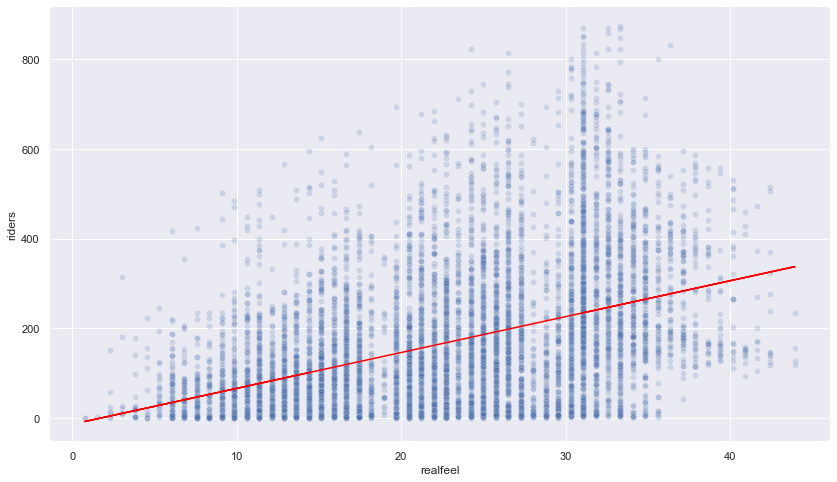

In [44]:
fig, axes = plt.subplots()

sns.scatterplot(x=X_train['realfeel'], y=y_train, alpha=0.2, ax=axes)
axes.plot(X_train['realfeel'], lr.coef_[0] * X_train['realfeel'] + lr.intercept_, color='red');

In practice, we don't use the formula itself with `model.intercept_` and `model.coef_`, we could just use `model.predict()`.

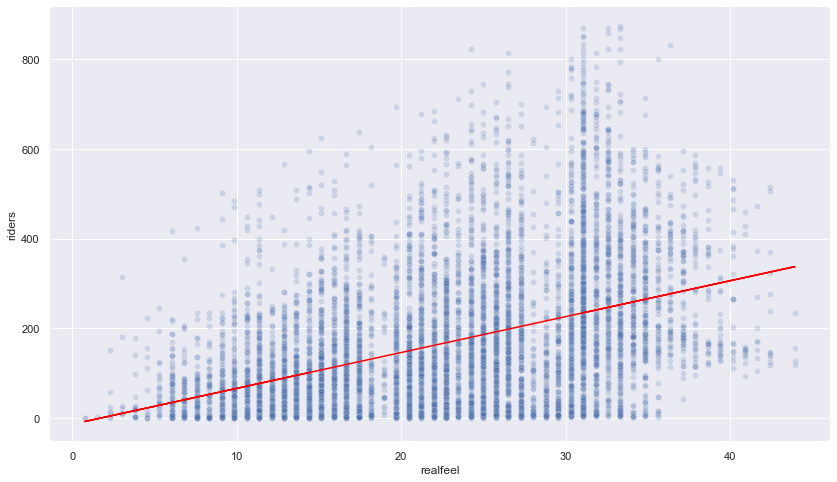

In [45]:
fig, axes = plt.subplots()

sns.scatterplot(x=X_train['realfeel'], y=y_train, alpha=0.2, ax=axes)
# note the use of .predict() instead of the formula for a line below
axes.plot(X_train['realfeel'], lr.predict(X_train[['realfeel']]), color='red');

Above we used real values from the dataset in `model.predict()`, but we can also put in other values that may or may not be have been previously seen by the model.

__Note__
- The warning below is just pointing out we trained our model on a dataframe with column names and asking it to predict a value from a list with no column names - its not a problem but its just giving us a heads up in case we made a mistake (which we have not).

In [46]:
lr.predict([[25.5]]).round()

C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([190.])

So above it is predicting there will be 190 riders when the temperature is 25.5 degrees celsius. To get this prediction, the model is just comparing where this feature value is against our regression line and finds the associated $y$ value.

C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


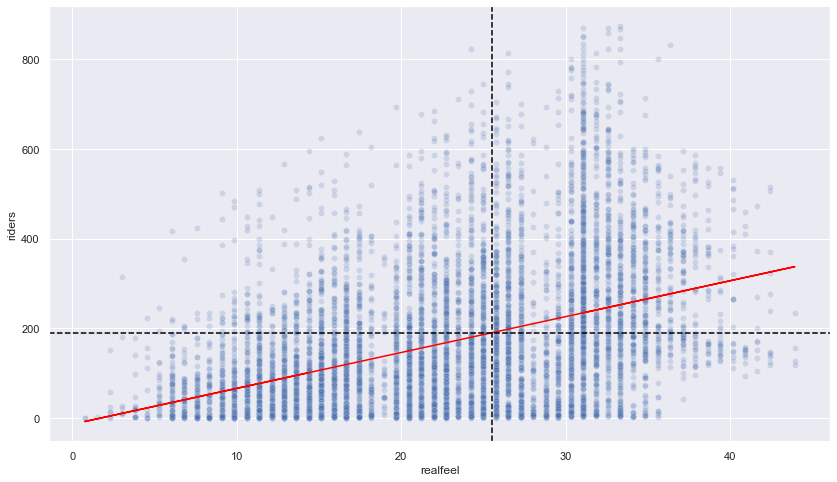

In [47]:
fig, axes = plt.subplots()

sns.scatterplot(x=X_train['realfeel'], y=y_train, alpha=0.2, ax=axes)
axes.plot(X_train['realfeel'], lr.predict(X_train[['realfeel']]), color='red')
axes.axvline(x=25.5, ls="--", c="black")
axes.axhline(y=lr.predict([[25.5]]), ls="--", c="black");

---

One question you may ask is: 

_"Does the scale of the features matter?"_

So in this case `realfeel` temperature is expressed in degrees Celsius - so would we get a different model if we converted it to degrees Fahrenheit?
$$F = 1.8C + 32$$

In [48]:
X_train['fahr'] = X_train['realfeel'] * 1.8 + 32
fahr_model = LinearRegression()
fahr_model.fit(pd.DataFrame(X_train["fahr"]), y_train)
print(fahr_model.intercept_.round(2), fahr_model.coef_.round(2))

-155.85 [4.44]


So we now have a different intercept and coefficient but thats because our data is on a different scale. If we make a prediction and convert it to fahrenheit...

In [49]:
# same predictions as before - make sure to convert the inputs to fahrenheit
fahr_model.predict([[25.5 * 1.8 + 32]]).round()

C:\Users\David_Elliott\anaconda3\envs\Programming_Basics\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([190.])

...we see it produces the same predicted values as before. If you want you can also plot the graph and check that it's the same line. The lesson here is that linear regression is __scale-invariant__: it doesn't care what scale the features are on.

Lets drop `fahr` as we won't need it again moving forward.

In [50]:
# drop our extra column as we won't need it again
X_train.drop('fahr', axis=1, inplace=True)

---

### 🚩 Exercise 14

Instead of `realfeel`, now use `humidity` as your predictor, and `riders` as your target. 

- Fit your model to the data.
- Examine the model coefficients and intercept.
- Plot the regression line on a scatterplot of the data.

__Note__
- Scikit-Learn will get confused if you try pass it a one-dimensional array (or Series), so make sure it is a dataframe or 2 dimensional numpy array to fix this error.

In [51]:
%run ../scripts/show_solutions.py 03_ex14

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 15
How many `riders` would this model predict if the `humidity` was 65?

In [52]:
%run ../scripts/show_solutions.py 03_ex15

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

## 6.2. Regression Evaluation

How do we check how good a model is? Rather than just getting the model to predict our training/validation sets and manually looking at what it predicted vs. what the real value was, we can use some metrics to summerise this for us and measure the quality of the predictions a model makes.

The two most commonly used metrics for regression models are r-squared score ("coefficient of determination" or "proportion of variance explained") and (root) mean squared error.

### R-Squared Score ($R^2$)

This says how much the variance of your dataset is reduced by based on the model's predictions. Equivalently, how much better your model is than just always guessing the mean (we discussed this more in workbook 01).

$R^2$ is calculated by dividing the total error of your model (residual sum of squares; RSS) by the total error if you used the mean value as your model (total sum of squares; TSS) and subtracting this from one,

$$R^2 = 1 - \frac{RSS}{TSS}.$$

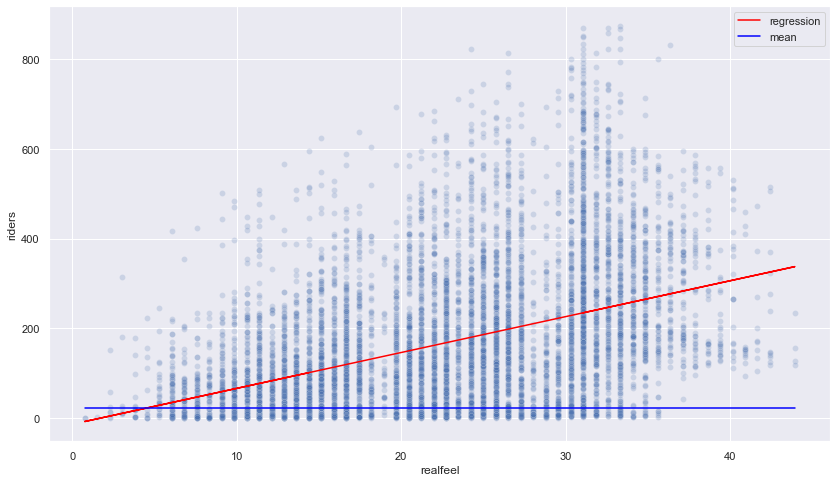

In [53]:
fig, axes = plt.subplots()

sns.scatterplot(x=X_train['realfeel'], y=y_train, alpha=0.2, ax=axes)
axes.plot(X_train['realfeel'], lr.predict(X_train[['realfeel']]), color='red', label='regression') # regression line
axes.plot([X_train['realfeel'].min(), X_train['realfeel'].max()], 
          (X_train['realfeel'].mean(), X_train['realfeel'].mean()), 
          color='blue', label='mean'); # mean line
axes.legend(loc='best');

In the example above, the blue line shows the mean number of riders across all our data - it's the baseline prediction we would make without using the features at all.

The red line is our regression line. We want to know how much better our predictions from the red line are than our baseline predictions from the blue line. This is what r-squared score tells us.

An r-squared score of 1 means the model is perfect - every prediction for which its performance has been measured is exactly correct so falls exactly on the red line. An r-squared score of 0 means the model is performing exactly as well as the baseline model (the mean), so would fall exactly on the blue line. A negative r-squared score means your model is worse than the baseline! So r-squared close to 1 is good, close to 0 is bad, negative is terrible. Values above 1 are not possible and it would be very unlikely to ever get 1 in reality (data rarely falls on a straight line).

Lets have a look how to calculate $R^2$ with Scikit-learn.

__Note__
- You could do below with `score = lr.score(pd.DataFrame(X_train["realfeel"]), y_train).round(2)` as $R^2$ is regressions default scoring method.
- I tend to use rounding to make metrics more interpretable.

In [54]:
from sklearn.metrics import r2_score

score = r2_score(y_train, lr.predict(X_train[["realfeel"]])).round(2)
score

0.17

So the r-squared score is 17% - so our points are 17% less spread out around the red (mean) line than they are around the blue (regression) line. Put another way, the model explains 17% of the variation in the dataset - the remaining 83% is down to other factors not yet in our model (e.g. time of day) and random variation. So we can conclude from this information alone we are not really able to predict the number of riders very well, but does give us some context. 

In real world scenarios there can be hundreds of factors that can explain a result, many of which won't have been captured in the data. With this in mind, a score of 17% may not be that bad. However, if this was instead a controlled experiment where there is only one or two factors that can explain the result, 17% would be pretty terrible. 

---
### 🚩 Exercise 16 (Extra)

You can compare your model to a `DummyRegressor` (from `sklearn.dummy`), to assess $R^2$ on the training and validation sets if no learning was happening. 

- What score would you expect for the training set?
- How does it compare to the `LinearRegression` model? 

In [55]:
%run ../scripts/show_solutions.py 03_ex16

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

--- 
However, R squared isn’t always the most appropriate metric as it relies on certain assumptions of linearity - such as all the features being independent of each other. Typically you should report several metrics when evaluating models anyway.

### Mean Absolute Error (MAE)

MAE is when for each residual you take the absolute value (ignore the sign, i.e. turn negative values into positive) and find the mean. The closer it is to 0 the better,

$$\text{MAE} = \frac{1}{n}\sum^n_{i=1}|y_i-\hat y_i|.$$

We take the absolute value, and not just calculate the mean error, as when we fit a model it will over predict some and under predict others, creating positive and negative residuals. If you find the mean of these, the positives and negatives will cancel each other out. This will leave an unrealistic representation of your error, and therefore the model’s efficiency.

In [56]:
from sklearn.metrics import mean_absolute_error as mae

mae(y_train, lr.predict(X_train[["realfeel"]])).round(2)

110.74

So is 110.74 good or not? Well, like $R^2$, its relative. Indeed this metric is useful to compare different models together with, the smaller the MAE, the better the model.

### Mean Squared Error (MSE)

Instead of taking the absolute value for each residual we can square them instead. Finding the mean of these values gives us another useful metric,

$$\text{MSE} = \frac{1}{n}\sum^n_{i=1}(y_i-\hat y_i)^2.$$

So, MSE looks at the error of each prediction (the difference between the predicted value and the true value), squares it (to make it positive and so larger errors are penalised more harshly), and then averages this over all points. MSE is non-negative and the closer to 0 the better!

In [57]:
# mean squared error
from sklearn.metrics import mean_squared_error as mse

mse(y_train, lr.predict(X_train[["realfeel"]])).round(2)

21258.93

### Root mean squared error (RMSE) 

RMSE is just the square root of the MSE,

$$\text{RMSE} = \sqrt{\frac{1}{n}\sum^n_{i=1}(y_i-\hat y_i)^2}.$$

It carries the same information, but on the same scale as the data. It is essentially (though not quite literally) the average amount your predictions are wrong by.

In [58]:
mse(y_train, lr.predict(X_train[["realfeel"]]), squared=False).round(2)

# or
#(mse(y_train, lr.predict(pd.DataFrame(X_train["realfeel"]))) ** 0.5).round(2)

145.8

So, in this case, our model's predictions on the training data are typically wrong by about 146 riders on average. So is this good or bad? To determine this we again need to put it in context, this time looking at the descriptive statistics.

In [59]:
y_train.describe().round(2)

count    8096.00
mean      167.17
std       160.32
min         1.00
25%        36.00
50%       124.00
75%       245.00
max       873.00
Name: riders, dtype: float64

As our true rider values can range from 1 to 873 (the mean being 167), being wrong on average by around 146 riders is not great! 

When thinking about how to use these metrics to determine how good your model is you can think of RMSE have a more direct interpretation in terms of the size of errors (it is roughly the average error), whereas r-squared score is more comparable across different contexts. It is impossible to say what value is good for RMSE without knowing about the context, whereas for r-squared score, good is close to 1, bad is close to 0, and it's less context-sensitive.

---

### Out-of-sample validation

So far we have been assessing the models performance on the training set, which is a good idea. But how do we know how well it would perform on new data it has not seen before (like it would be used for when predicting possible future bike rentals)? Well currently we don't know, so thats why we should have a look at its performance on the validation set.

__Note__
- Remember while we are improving our models, we shouldnt be using our test set. We use the test set at the very end, once we are happy with our model, to get a final evaluation of generalisation performance.

---

### 🚩 Exercise 17

Evaluate the performance of the separate `realfeel` and `humidity` models on the validation set.
- How do these scores compare to their scores on the training set?

In [60]:
%run ../scripts/show_solutions.py 03_ex17

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

Using a single split is useful, but it's worth looking over a number of possible splits to see how the model performs. In the case of Time Series data, like with our validation split, we shouldn't really be randomly splitting our data and mixing future and past data together if we are going to be using this model to predict future numers of riders. To get a realisitic idea of performance we should be training the model on some data and predicting how it performs on data that was collected afterwards (like we would use it in practice). Therefore we should be using a `TimeSeriesSplit`.

`TimeSeriesSplit` splits the data sequentially so that successive training sets are supersets of those that come before them. So for our data each iteration will look like something below...

__Notes__
- We have 7 business quaters left in our data (test set is the last quater), so lets split into 7 folds.
- Notice how we are now using `X_train_full`. We dont need to use the smaller data made after splitting off the validation set (`X_train`, `X_val`) because this is going to be making these splits for us. We still need our `X_test` data though!

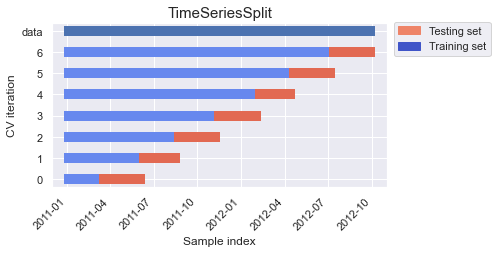

In [61]:
from helper_functions import plot_cv_indices
from sklearn.model_selection import TimeSeriesSplit

n_splits=7

tscv = TimeSeriesSplit(n_splits)

fig, axes = plt.subplots(figsize=(6, 3))
axes = plot_cv_indices(tscv, X_train_full, axes, n_splits)

...or to be specific:

__Note__
- These are not falling exactly on the start and end of quaters due to the missing data, but for our purposes in this workshop we'll say they are close enough.

In [62]:
for i, (train_index, val_index) in enumerate(tscv.split(X_train_full)):
    X_train_index, X_val_index = X_train_full.index[train_index], X_train_full.index[val_index]
    
    print("fold "+ str(i))
    print("training: " + str(X_train_index[0]) + " to "+ str(X_train_index[-1]))
    print("validation: " + str(X_val_index[0]) + " to "+ str(X_val_index[-1]))
    print()

fold 0
training: 2011-01-01 00:00:00 to 2011-03-14 12:00:00
validation: 2011-03-14 13:00:00 to 2011-06-07 06:00:00

fold 1
training: 2011-01-01 00:00:00 to 2011-06-07 06:00:00
validation: 2011-06-07 07:00:00 to 2011-08-18 20:00:00

fold 2
training: 2011-01-01 00:00:00 to 2011-08-18 20:00:00
validation: 2011-08-18 21:00:00 to 2011-11-11 14:00:00

fold 3
training: 2011-01-01 00:00:00 to 2011-11-11 14:00:00
validation: 2011-11-11 15:00:00 to 2012-02-04 07:00:00

fold 4
training: 2011-01-01 00:00:00 to 2012-02-04 07:00:00
validation: 2012-02-04 08:00:00 to 2012-04-16 01:00:00

fold 5
training: 2011-01-01 00:00:00 to 2012-04-16 01:00:00
validation: 2012-04-16 02:00:00 to 2012-07-08 15:00:00

fold 6
training: 2011-01-01 00:00:00 to 2012-07-08 15:00:00
validation: 2012-07-08 16:00:00 to 2012-10-01 05:00:00



If we have a look at our `realfeel` model over multiple splits we see it consistently performs poorly across each successive quater. Unsurprisingly, due to the smaller amount of data, the first fold is the worst performing, but performance doesn't improve much by each successive quater. So although looking at the training data may have made us think this was an okay model, validating it this way confrims to us this model is pretty poor.

__Note__
- `make_scorer` is just a way of turning a scoring metric compatible with cross-validation methods.

In [63]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer

# tidy the output into a dataframe
def tidy_scores(score_dict):
    df = pd.DataFrame(score_dict)
    df.loc['mean'] = df.mean()
    df.loc['sd'] = df.std()
    df.rename({"test_r2":"val_r2"}, axis=1, inplace=True)
    df.rename({"test_RMSE":"val_RMSE"}, axis=1, inplace=True)
    df.index.name = "fold"
    return df.round(2)

scores = cross_validate(LinearRegression(), 
                        X_train_full[["realfeel"]], y_train_full, 
                        cv=TimeSeriesSplit(n_splits= 7), 
                        scoring = {"r2": make_scorer(r2_score), 
                                   "RMSE": make_scorer(mse, **{"squared":False})},
                        return_train_score=True)
tidy_scores(scores)

,fit_time,score_time,val_r2,train_r2,val_RMSE,train_RMSE
fold,,,,,,
0,0.00,0.00,0.03,0.10,128.42,58.09
1,0.02,0.00,0.09,0.27,143.37,93.53
2,0.00,0.00,0.09,0.27,137.84,112.31
3,0.00,0.00,-0.10,0.23,124.35,119.02
4,0.00,0.00,-0.02,0.18,186.87,119.40
5,0.00,0.02,-0.01,0.16,217.65,132.36
6,0.00,0.00,0.03,0.18,228.02,146.94
mean,0.00,0.00,0.02,0.20,166.65,111.66
sd,0.01,0.01,0.06,0.06,40.36,26.69


---

### 🚩 Exercise 18 (Extra)

Use `cross_validate` on the `humidity` feature model to see how it performs over different splits of our data.

In [64]:
%run ../scripts/show_solutions.py 03_ex18

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

## 6.3. Multiple Regression

So far we have been looking at a case where there is only one predictor, but is there a limit to how many predictor variables you are allowed? Absolutely not - you can have as many predictor variables as you like! All you do is add a new effect size/coefficient for each new predictor,

$$\hat y = \beta_0 + \beta_1x_1 + ... + \beta_nx_n + \epsilon.$$

Lets try add another feature into our model. When selecting features for a linear model, it is a good idea to try select one thats correlates strongly with the target (positively or negatively) but weakly with each other. 

Using our prior heatmap above, either `realfeel` or `temp` were the strongest predictor of riders, but we should not use both (as they correlate strongly with each other). `humidity` was the next strongest predictor of riders, and doesn't correlate with `temp` or `realfeel`, so using `temp` and `humidity` together seems sensible.

---

### 🚩 Exercise 19

Have a go at fitting a model to `realfeel` and `humidity` on the training set, and evaluating r-squared score and RMSE on the training and validation sets (using the single split or cross-validation).
- How does it compare to the single `realfeel` or `humidity` feature model?

In [65]:
%run ../scripts/show_solutions.py 03_ex19

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### Feature Engineering

Lets add another feature, but this time, lets do a bit of feature engineering to create it!

As its likely that time of day is going to be important (probably not as many 2am bike rentals!) let's look at extracting the time of day to use in our model. However, it's not directly available - it's buried inside a complicated datetime object. Our regression model will need to take a numeric column, so we need to manipulate the datetime object to extract what we want. This kind of manipulation to extract information from feature columns in a form your model can work with is called <em>feature engineering</em>.

__Note__
- We will look more in depth at datetime objects in a later time series workbook.

In [66]:
print(X_train.index[1])

# we can pull hour (or other parts of the datetime) from an individual datetime like so
X_train.index[1].hour

2011-01-01 01:00:00


1

We could define a function to extract the hour from a datetime object...

In [67]:
def extract_hour(dt):
    return dt.hour

...and then apply this to every element of the index in turn.

__Note__

- we use `.map` to apply a function to the index, but `.apply` to apply it any regular column
- we could also use `lambda` expressions: `X_train.index.map(lambda dt: dt.hour)`

In [68]:
X_train.index.map(extract_hour)

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
             7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
           dtype='int64', name='datetime', length=8096)

Lets turn this step into a function as well.

In [69]:
from sklearn.preprocessing import FunctionTransformer

def create_hour_feat(data):
    data_ = data.copy()
    data_['hour'] = data_.index.map(extract_hour)
    return data_

# make compatible with a scikit-learn pipeline
hour_feat_func = FunctionTransformer(func=create_hour_feat,    # our custom function
                                     validate=False)           # prevents input being changed to numpy arrays

X_train_ = hour_feat_func.fit_transform(X_train[["realfeel", "humidity"]])
X_train_.head()

,realfeel,humidity,hour
datetime,,,
2011-01-01 00:00:00,14.395,81,0
2011-01-01 01:00:00,13.635,80,1
2011-01-01 02:00:00,13.635,80,2
2011-01-01 03:00:00,14.395,75,3
2011-01-01 04:00:00,14.395,75,4


We can check if our new column correlates with the target.

In [70]:
import scipy.stats
corr, P = scipy.stats.pearsonr(X_train_["hour"], y_train)

print("Pearson’s correlation coefficient : " + str(corr.round(2)))
print("P-Value : " + str(P.round(2)))

Pearson’s correlation coefficient : 0.4
P-Value : 0.0


It's got a good correlation - slightly more so than `temp` or `realfeel`. Let's look in more detail. We could use a scatterplot, but not very interpretable in this instance...

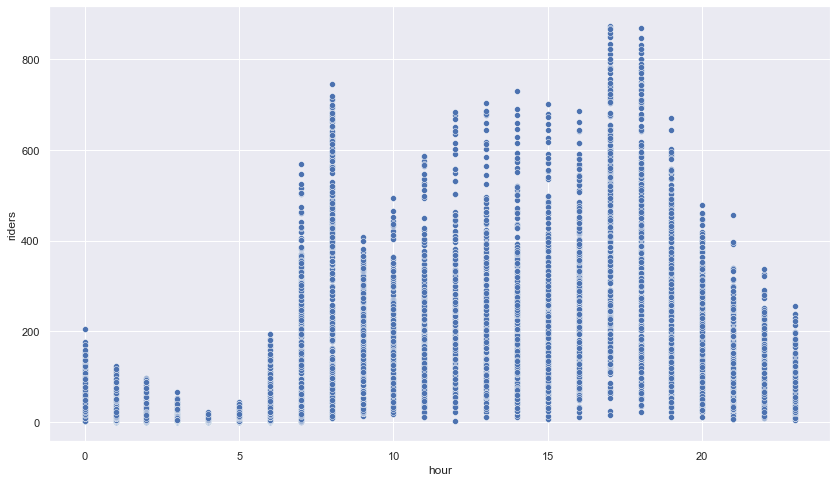

In [71]:
sns.scatterplot(x=X_train_['hour'], y=y_train);

...so lets instead take the average number of riders for each hour.

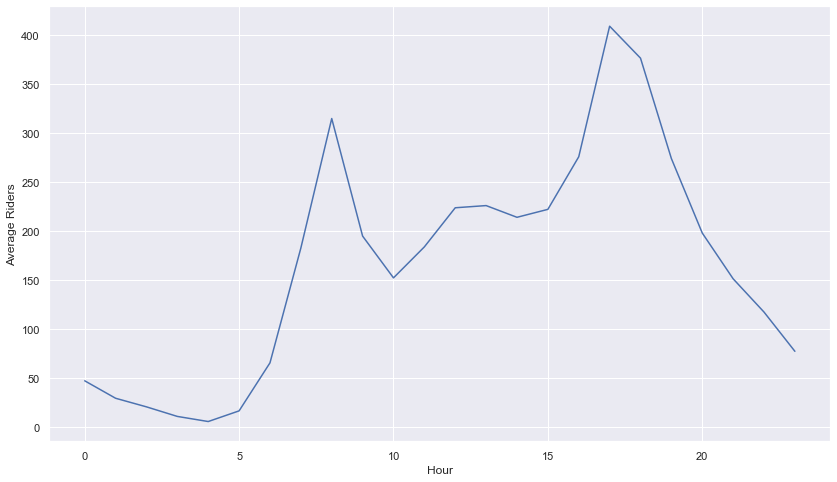

In [72]:
vis_data = X_train_.copy()
vis_data["riders"] = y_train
sns.lineplot(data = vis_data.groupby('hour')["riders"].mean())
plt.xlabel("Hour")
plt.ylabel("Average Riders")
plt.show()

There isn't a clear linear trend, it changes direction and there are sudden drops (peaking around commuting hours). Also we have the cyclic nature of hour of day - it loops back from 23 to 0. So treating hour as a numeric value in a linear model is probably going to give us issues. Instead we could treat it like a categorical variable - treat each hour as simply a separate category from the others.

Categorical variables are included using binary "dummy variables". E.g., to add a "sunny/rainy" column in, we'd create a dummy variable which is 0 when sunny, 1 when rainy (or the other way around). For more than two categories, we can use multiple dummy variable columns. So we have a hour_0 column (1 if hour=0, 0 otherwise), and hour_1 column (1 if hour=1, 0 otherwise), etc.

Lets have a look at what this looks like using Pandas.

In [73]:
pd.get_dummies(X_train_, columns=['hour']).head()

,realfeel,humidity,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,14.395,81,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 01:00:00,13.635,80,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 02:00:00,13.635,80,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 03:00:00,14.395,75,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 04:00:00,14.395,75,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__Warning:__
When creating dummy variables, you should drop the first one for a regression model. Otherwise n-1 of the dummy columns perfectly determine the nth (if there's a 0 in the first n-1 columns, there must be a 1 in the last, otherwise there must be a zero) giving _multicollinearity_. This can cause the model to produce highly unstable, and sometimes nonsense results.

Therefore, if using `pd.get_dummies` to create your dummy variables, then just add `drop_first=True`.

In [74]:
pd.get_dummies(X_train_, columns=['hour'], drop_first=True).head()

,realfeel,humidity,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,14.395,81,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 01:00:00,13.635,80,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 02:00:00,13.635,80,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 03:00:00,14.395,75,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 04:00:00,14.395,75,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we have a bunch of 0's and 1's. 

Instead of using Pandas we can use the handy `OneHotEncoder` from Sklearn to do this for us - which has the added benefit that it stores the data in a more memory efficient way to account for all the 0's and 1's we now have!

However we need to pair this with a `ColumnTransformer` to tell scikit-learn which column(s) we want to apply the transformation to otherwise it will try create dummy variables for all our features (i.e. `realfeel` and `humidity` as well!).

__Note__
- We can always turn it back to a pandas dataframe if we want to (e.g. `pd.DataFrame.sparse.from_spmatrix`) or define `sparse = False` in the `OneHotEncoder` to not return a "sparse matrix".

In [75]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

hour_onehot = ColumnTransformer(
    # apply the `OneHotEncoder` to the "hour" column
    [("OHE", OneHotEncoder(drop="first"), ["hour"])],
    # don't touch all other columns, instead concatenate it on the end of the
    # changed data.
    remainder="passthrough"
) 

X_train_ = hour_onehot.fit_transform(X_train_)
X_train_

<8096x25 sparse matrix of type '<class 'numpy.float64'>'
	with 23927 stored elements in Compressed Sparse Row format>

Lets add our new feature creation into a pipeline and fit the model.

In [76]:
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

# create our pipeline for the data to go through.
# This is a list of tuples with a name (useful later) and the function.
lin_dummy_pipe = Pipeline([
    ("create_hour", hour_feat_func),
    ("encode_hr", hour_onehot),
    ("model", LinearRegression())
])

lin_dummy_pipe.fit(X_train[["realfeel", "humidity"]], y_train)

Pipeline(steps=[('create_hour',
                 FunctionTransformer(func=<function create_hour_feat at 0x000002227C52D4C0>)),
                ('encode_hr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OHE',
                                                  OneHotEncoder(drop='first'),
                                                  ['hour'])])),
                ('model', LinearRegression())])

If we look at the coefficients for our dummy variables, they now tell us the change in the value of the dependent variable (or "outcome") compared with the base case.

In [77]:
# look at intercept and coefficients
print("Intercept: " + str(lin_dummy_pipe["model"].intercept_.round(2)))

# combine the coefficients with the feature names
coefs = pd.DataFrame(
    lin_dummy_pipe["model"].coef_,
    index = lin_dummy_pipe["encode_hr"].get_feature_names_out(),
    columns = ["Coefficients"]
)

coefs

Intercept: -10.82


,Coefficients
OHE__hour_1,-13.407737
OHE__hour_2,-19.630794
OHE__hour_3,-27.780350
OHE__hour_4,-27.711936
OHE__hour_5,-13.876301
OHE__hour_6,36.695887
OHE__hour_7,150.523924
OHE__hour_8,276.000278
OHE__hour_9,145.241677
OHE__hour_10,91.413443


So by looking at `OHE__hour_1` above for example we know that the model expects ~13 fewer riders around 1am than around midnight (`OHE__hour_0`). This makes sense... the later at night it gets the less people will be around.

__Note__
- `"OHE"` comes from what we named the transformer in the `ColumnTransformer`.
- Notice how we are accessing parts of the pipeline below by indexing their names we gave them in the code block above (e.g. `lin_dummy_pipe["model"]`).

---

### 🚩 Exercise 20

Using the coefficients above, how does the model expect the number of riders to change according to the time?

In [78]:
%run ../scripts/show_solutions.py 03_ex20

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

Lets see how this model performs now we have added this feature...

In [79]:
scores = cross_validate(lin_dummy_pipe, 
                        X_train_full[['humidity', "realfeel"]], y_train_full, 
                        cv=TimeSeriesSplit(n_splits= 7), 
                        scoring = {"r2": make_scorer(r2_score), 
                                   "RMSE": make_scorer(mse, **{"squared":False})},
                        return_train_score=True)
tidy_scores(scores)

,fit_time,score_time,val_r2,train_r2,val_RMSE,train_RMSE
fold,,,,,,
0,0.01,0.00,0.28,0.63,110.98,37.12
1,0.02,0.00,0.59,0.64,95.96,65.61
2,0.01,0.00,0.59,0.67,91.91,74.80
3,0.02,0.00,0.50,0.66,83.38,78.75
4,0.00,0.02,0.47,0.64,134.56,78.88
5,0.00,0.00,0.48,0.62,156.34,89.28
6,0.01,0.01,0.52,0.62,160.09,100.12
mean,0.01,0.01,0.49,0.64,119.03,74.94
sd,0.01,0.01,0.10,0.02,29.09,18.47


...so much better training and validation scores than before adding the hour, with the difference between the training and validation sets not too bad! We can also see this when looking at the predictions these models make by looking at the below scatterplot of predictions against reality. 

If all predictions are perfect, then these points should lie on the line $y=x$, so the spread of these points around that line lets us visualise the model error.

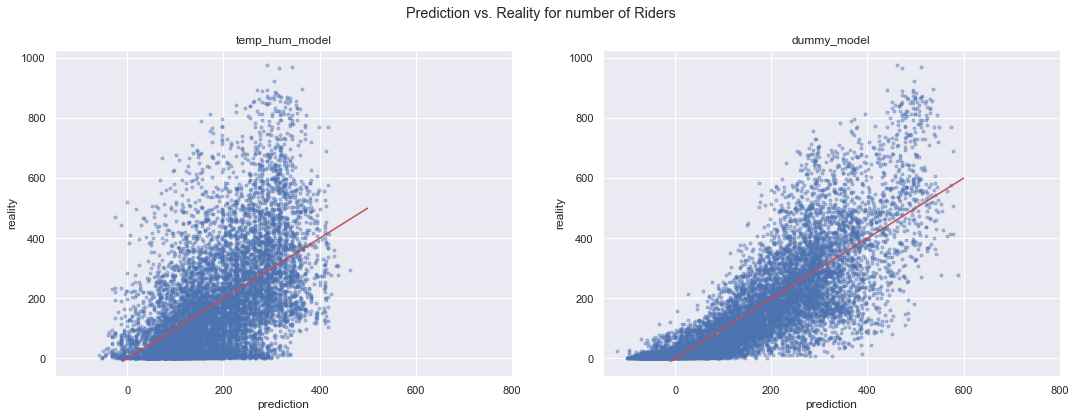

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

temp_hum_model = LinearRegression()
# for our older model
temp_hum_model.fit(X_train_full[['humidity', 'realfeel']], y_train_full)
ax[0].plot(temp_hum_model.predict(X_train_full[['humidity', 'realfeel']]), y_train_full, '.', alpha=0.4) # scatter predictions vs reality
ax[0].plot([-10, 500], [-10, 500], 'r') # plot line y=x
ax[0].set_title('temp_hum_model')
ax[0].set_xlabel('prediction')
ax[0].set_ylabel('reality')

# for our newer model
lin_dummy_pipe.fit(X_train_full[['humidity', 'realfeel']], y_train_full)
ax[1].plot(lin_dummy_pipe.predict(X_train_full[['humidity', 'realfeel']]), y_train_full, '.', alpha=0.4) # scatter predictions vs reality
ax[1].plot([-10, 600], [-10, 600], 'r') # plot line y=x
ax[1].set_title("dummy_model")
ax[1].set_xlabel('prediction')
ax[1].set_ylabel('reality')

# get them on the same scale
ax[0].set_xlim(-150, 800)
ax[1].set_xlim(-150, 800)

fig.suptitle("Prediction vs. Reality for number of Riders");

We can see that the model with the dummy variables in for the `hour` (`dummy_model`) is making predictions much closer to reality (red line), however it seems to still have problems at the tail ends of the values (where there are very few riders and very many) - indeed the models will sometimes predict negative riders which... doesnt really make sense but the points predicted negative do all have low actual riders, so it's not a disaster - we just need to interpret a negative prediction as being a prediction of 0.

---

### 🚩 Exercise 21

Add further time information to your model to see if this improves it. 

<br>
<details><summary><b><u>Hints</b></u></summary>
    
- Months are cyclic (like hours), so will need to be encoded as dummy variables (remembering to ```drop_first```!)
- If you try use "years" you will likely run into an error as we don't have enough data to account for this.
- If you cross-validate the model with "Month" as a variable, it will produce an error in the validation score until the model is trained on more than one years worth of data.
</details>

In [81]:
%run ../scripts/show_solutions.py 03_ex21

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

# 7. Summary <a id='sum'></a>

Although our models continue to get better, it seems that we have a problem with our models performing better on our training set than our validation set. In otherwords there is a _variability_ in our models performance between when we use data we have trained on and similar data when validated. We also have some _bias_ in there, our model is generally under-predicting values at the tail ends (low and high values). We will look at how to try and find a ballance between these in the next notebook.

However, for the sake of this workbook you are now done - well done! Hopefully you feel we have addressed the aim of getting an overview of how to use linear regression in a typical machine learning project.

We started by preparing our data for analysis by tidying it up a little bit. Then we explored our data using descrptive statistics and visualisations. This helped us when deciding what features would be useful for our model prediction. Then, after preparing our data for modelling, we started to explore different features in a linear regression, and refining it. If you want to carry on refining your model, then you can continue with the extra exercises below.

## Comparing Linear Regression With Other Models

__Advantages of linear regression__

- Simple to explain
- Highly interpretable
- Model training and prediction are fast
- No tuning is required (excluding regularization)
- Features don’t need scaling.
- Can perform well with a small number of observations.
- Well understood.

__Disadvantages of linear regression__

- Presumes a linear relationships between the features and the response.
- Performance is (generally) not competitive with the best supervised learning methods due to high bias.
- Can’t automatically learn feature interactions.


---

# 8. Extra <a id='extra'></a>

## Regression with Statsmodels

So far we have only been sci-kit learn to build our models, but there are other packages to build regression models, such as `statsmodels`. While `statsmodels` has a different syntax (more similar to how you create linear models in the programming language R), they build the same model but provide a different output.

`statsmodels` is a great choice if you want to have more through outputs from your model, and particularly if you want to conduct a hypothesis test on how much influence a predictor has on a target.

For example, before we wanted to use `realfeel` to predict the number of `riders`. Instead we could frame this as a hypothesis test at the 5% level:

H$_0$: The temperature feel has no effect on the number of riders<br>
H$_1$: The temperature feel has an effect on the number of riders

Lets start by importing the `statsmodels` library.

In [82]:
import statsmodels.api as sm

Now we can fit out model. Notice how the syntax is different. `y_train` and `X_train` are the other way round to what we had before.

In [83]:
model= sm.OLS(y_train,X_train[["realfeel"]]) 

fitted_model=model.fit()
fitted_model

Using the above fitted model, we can now look at our performance metrics using `.summary`.

In [84]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 riders   R-squared (uncentered):                   0.603
Model:                            OLS   Adj. R-squared (uncentered):              0.603
Method:                 Least Squares   F-statistic:                          1.231e+04
Date:                Wed, 07 Dec 2022   Prob (F-statistic):                        0.00
Time:                        15:22:07   Log-Likelihood:                         -51828.
No. Observations:                8096   AIC:                                  1.037e+05
Df Residuals:                    8095   BIC:                                  1.037e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
realfeel       7.4567      0.067    110.948      0.000       7.325       7.588
==============================================================================
Omnibus:                     1467.000   Durbin-Watson:                   0.369
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2628.088
Skew:                           1.152   Prob(JB):                         0.00
Kurtosis:                       4.575   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It looks okay... but if you scroll back up you will see that the intercept, coefficients, and R-squared values are different than teh on produced using scikit learn. Indeed this is because by default the model does not have an intercept. We can see this more clearly if we plot the model.

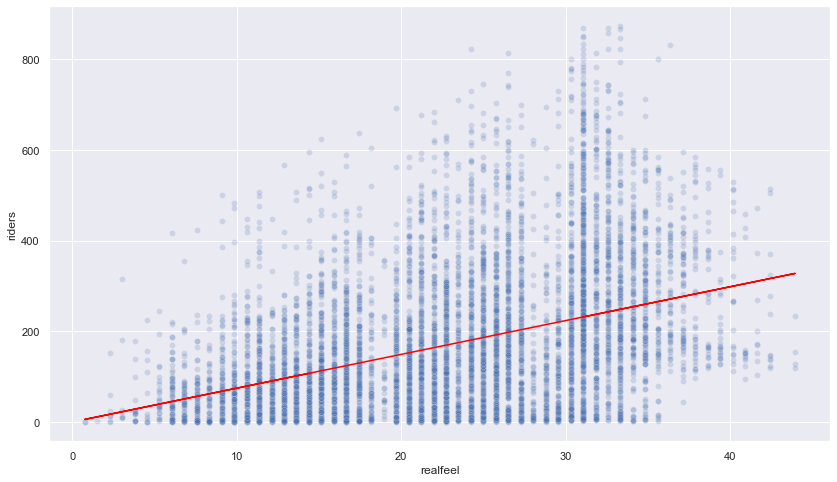

In [85]:
fig, axes = plt.subplots()

sns.scatterplot(x=X_train['realfeel'], y=y_train, alpha=0.2, ax=axes)
# note the use of .predict() instead of the formula for a line below
axes.plot(X_train['realfeel'], fitted_model.predict(X_train[['realfeel']]), color='red');

So an important step when using `statsmodels` is to add a constant to your data first, because without it, your model will  assume that regression will cross the y axis at x=0.

In [86]:
X_train_sm = sm.add_constant(X_train[["realfeel"]])

X_train_sm

,const,realfeel
datetime,,
2011-01-01 00:00:00,1.0,14.395
2011-01-01 01:00:00,1.0,13.635
2011-01-01 02:00:00,1.0,13.635
2011-01-01 03:00:00,1.0,14.395
2011-01-01 04:00:00,1.0,14.395
...,...,...
2012-06-17 12:00:00,1.0,31.060
2012-06-17 13:00:00,1.0,31.060
2012-06-17 14:00:00,1.0,31.060


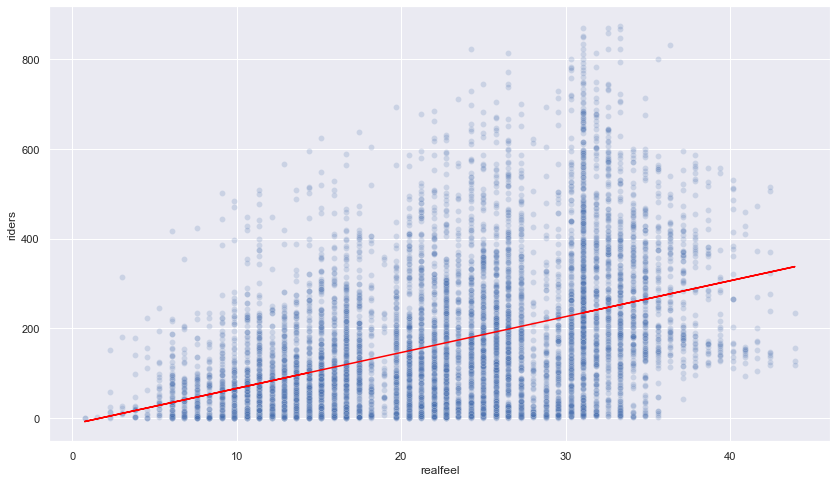

In [94]:
fitted_model = sm.OLS(y_train,X_train_sm).fit()
fig, axes = plt.subplots()

sns.scatterplot(x=X_train['realfeel'], y=y_train, alpha=0.2, ax=axes)
# note the use of .predict() instead of the formula for a line below
axes.plot(X_train['realfeel'], fitted_model.predict(X_train_sm), color='red');

Now admittedly in this case, its not made much of a difference, but in some models it definately will! Lets look at the metrics again.

In [91]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 riders   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     1690.
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        15:22:57   Log-Likelihood:                -51824.
No. Observations:                8096   AIC:                         1.037e+05
Df Residuals:                    8094   BIC:                         1.037e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.7663      4.690     -2.935      0.003     -22.960      -4.573
realfeel       7.9922      0.194     41.110      0.000       7.611       8.373
==============================================================================
Omnibus:                     1399.334   Durbin-Watson:                   0.370
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2453.557
Skew:                           1.114   Prob(JB):                         0.00
Kurtosis:                       4.518   Cond. No.                         69.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now if you scroll back up you will see that the intercept, coefficients, and R-squared values are the same. `.summary` also gives us a number of additional metrics to consider. Rather than go through all of them, lets just focus on some of them relvent to assessing our hypthothesis test:

__std err__ is the level of accuracy of the coefficients. The lower it is, the higher is the level of accuracy.

__P >|t|__ is your p-value. A p-value of less than 0.05 is typically considered to be statistically significant.

__Confidence Interval__ represents the range in which our coefficients are likely to fall (with a likelihood of 95%).

https://datatofish.com/statsmodels-linear-regression/

So going back to our original hypothesis test, with this information we can say we have enough evidence to reject the null hypothesis and say that there is a statistically significant effect of temperature feel on the number of riders as the P-value is less than 0.05.

__Note__
- To say something has a "statistically significant effect" is different from saying it has a "large effect"!

---

### 🚩 Exercise 22

Use `statsmodels` to test the following hypothesis at the 5% level:

H$_0$: The humidity has no effect on the number of riders<br>
H$_1$: The humidity has an effect on the number of riders

In [88]:
%run ../scripts/show_solutions.py 03_ex22

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
So we've looked at the training set, what now about using the model to predict and assess a validation set?

Well to make predictions its `.predict`...

In [95]:
val_pred = fitted_model.predict(sm.add_constant(X_val[["realfeel"]]))
val_pred

datetime
2012-06-17 17:00:00    234.471870
2012-06-17 18:00:00    234.471870
2012-06-17 19:00:00    234.471870
2012-06-17 20:00:00    234.471870
2012-06-17 21:00:00    234.471870
                          ...    
2012-10-01 01:00:00    161.822633
2012-10-01 02:00:00    167.856755
2012-10-01 03:00:00    161.822633
2012-10-01 04:00:00    155.748549
2012-10-01 05:00:00    161.822633
Length: 1429, dtype: float64

Then with these predictions we can evaluate the performance of the model using things from scikit-learn (which is more geared towards prediction modelling) as before. For example...

In [98]:
r2 = r2_score(y_val, val_pred).round(2)
rmse = (mse(y_val, val_pred) ** 0.5).round(2)

print("Realfeel Validation Scores")
print("R^2: " + str(r2))
print("RMSE: " + str(rmse))

Realfeel Validation Scores
R^2: 0.04
RMSE: 220.73


---

## Additional Questions

Here are some extra exercises that cover some of the other steps in a machine learning project. You may want to try these to improve your skills in these areas as well.

__TODO__
- Further refinement exercise
- Assess performance of final model on the test set
- Question around how to write up the results (Solution Presentation)